# Liklihood of Vehicle Damage among Health Insurance Owners
*By Kian Kermani
\
ID: 11586591*
## Table of Contents

### Introduction
    
    Processing the data
    Problem description

### Supervised Learning models

    Multivariable Logistic Regression
    Random Forest
    k-NN (k-Nearest Neighbor)
    
### Unsupervised Learning models
    
    K-Means Clustering
    tSNE (t-distributed stochastic neighbor embedding)
    
### Conclusion

## Introduction

In this project, we will explore a dataset from a Health Insurance company. The orginal goal of this dataset was to predict whether a customer would be interested in purchasing vehicle insurance by the company. In our project, we will try to explore other outcomes, such as whether an individual has ever had their vehicle damaged based off a selection of observations.

### Processesing the data

For this data set, we will store everything into a pandas Data Frame at first, so that we may eventually turn our Data Frame into a numpy array. The Data Frame will contain strings and we would like to replace them with a numerical value. We will be using the replace method from pandas in order to accomplish this.
\
\
There have been some choices made in regards to how we will analyze the data. We have decided to drop certain variables such as vehicle age, possession of a drivers license, and others which can be seen below. The reason for this is that we want to try to eliminate certain noise that the other variables generate. We found our results to be more accurate based off of the selections that we have made.
To briefly go further into why this choice was made, consider the drivers license data. Based on the original dataset, nearly all individuals have a drivers license, thus it does not make sense to include this as a way to predict vehicle damage. There could be an argument made in favor of keeping vehicle age however, but in our testing, we did not find any change in our models ability to predict accuractely when that observation was included.

\
Among those that we have selected are:
\
Gender, Age, Previously_Insured, and Response to whether they are interested in Vehicle insurance.

In [40]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore') # to supress unimportant warnings that kept popping up

df = pd.DataFrame(pd.read_csv('Ftrain.csv'))
df = df.drop(['id', 'Driving_License','Region_Code','Vehicle_Age','Policy_Sales_Channel','Vintage','Annual_Premium'], axis = 1)
# removal of unwanted variables
df.head()

,Gender,Age,Previously_Insured,Vehicle_Damage,Response
0,Male,44,0,Yes,1
1,Male,76,0,No,0
2,Male,47,0,Yes,1
3,Male,21,1,No,0
4,Female,29,1,No,0


In [41]:
df = df.replace(to_replace='Male', value =1)    # Since strings were binary, we use 1 or 0 to represent in numeric form
df = df.replace(to_replace='Female', value =0)
df = df.replace(to_replace='Yes', value =1)
df = df.replace(to_replace='No', value =0)
df.head()

,Gender,Age,Previously_Insured,Vehicle_Damage,Response
0,1,44,0,1,1
1,1,76,0,0,0
2,1,47,0,1,1
3,1,21,1,0,0
4,0,29,1,0,0


In [42]:
df.describe() # description of basic statistics on the dataset

,Gender,Age,Previously_Insured,Vehicle_Damage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,0.540761,38.822584,0.458210,0.504877,0.122563
std,0.498336,15.511611,0.498251,0.499977,0.327936
min,0.000000,20.000000,0.000000,0.000000,0.000000
25%,0.000000,25.000000,0.000000,0.000000,0.000000
50%,1.000000,36.000000,0.000000,1.000000,0.000000
75%,1.000000,49.000000,1.000000,1.000000,0.000000
max,1.000000,85.000000,1.000000,1.000000,1.000000


In [43]:
X = df.loc[:,['Gender', 'Age', 'Previously_Insured', 'Response']].values # conversion to a numpy array
X = (X-np.mean(X,axis=0))/np.std(X+1e-10,axis=0) # renormalize to avoid nan issues
y = df['Vehicle_Damage'].values

In [44]:
X.shape

(381109, 4)

As mentioned previously, the data has been cleaned by dropping certain variables and encoding strings with numeric values. We then split the dataframe into two numpy arrays by using the .values method, one for the observations and one for the labels/classes. X, the observation set, has been renormalized to allow for smoother process when we begin training our models. Additionally, we have shown the statistics of the data above. We see for example the average individual in this data is likely to be male and around 38 years of age.

### Problem Description
We will begin the supervised learning portion of this project to address the problem of predicting whether an individual has ever recieved damage to their vehicle based off of a few key variables. Three models will be used for this portion: Multivariable Logistic Regression, Random Forest, and k-Nearest Neighbors. Afterward, we will use two unsupervised learning models to further explore the data. **All notion of accuracy will be solely based on the models ability to predict if an individual has experienced damage to their vehicle**. Any mention of score or accuracy in this report will refer to this.

## Surpervised Learning models

### Multivariable Logistic Regression

Since this problem is of the binary classification nature, it seems logical to have our first supervised learning model be one of logistic regression. Here, we take in many different variables $x$ and try to predict $y$ based on probabilities to take on value 0 or 1. 

$$P(y=1|\mathbf{x})=f(\mathbf{x};\mathbf{\beta}) = \frac{1}{1 + \exp(-\tilde{x}\mathbf{\beta})}
=: \sigma(\tilde{x}\mathbf{\beta}). $$

Our sigmoid function in this model will be taking in what can be thought of as two "lists" where $\beta = (\beta_0,\beta_1,...,\beta_p) \in \mathbb{R}^{p+1}$
and $\tilde{x}=(1,x_1,...,x_p)$. The first elements in both "lists" account for the intercept. We can think of the multiplication of these two lists as an inner product.

Assuming the samples are independent. The overall probibility to witness the whole training dataset is given by
$$ P(\mathbf{y}\; | \; \mathbf{X};\beta )$$


In order to solve the optimization problem, i.e minimizing the loss function, we will need to employ gradient desccent or stochastic gradient descent. In the model created below, we have the option of doing either. However, we end up choosing to use only stochastic gradient descent.

Before we do anything we need to split our data into testing and training. To do this, we import train_test_split from sklearn.model_selection in order to easily acccomplish this task. We have decided to choose a test size of 30%. That means that 70% of the data will be used for training.

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state = 22)

Next, we need to create the logistic regression class. We will abide by standard procedures of creating a class that allows us to create instances of a model that can solve the multi-variable binary-class problem.

In [47]:
class LogisticRegression():
    
    def __init__(self,learning_rate=0.1, opt_method='GD', num_epochs=40, size_batch=20):
        '''We initialize the object of class LogisticRegression. Attributes include learning_rate,
        opt_method, num_epochs, size_batch. Which account for the learning rate, method of gradient descent or stochastic
        gradient descent, number of epochs, and batch size respectively. Call each variable by using
        self.() where the () may be replaced by any of the attribute names listed above.'''
        self.learning_rate = learning_rate
        self.opt_method = opt_method
        self.num_epochs = num_epochs
        self.size_batch = size_batch
        
    def fit(self, data, y, n_iter=200):
        '''We have our fit function which is designed to work in the case of multi variable, binary class logistic regression.
        This method takes in data (your dataset), y (your classes), and number of iterations, n_iter=200 is default.
        We also create an augmented matrix X by concatenating a ones column. We do this to allow for a linear beta_0 term.
        We then follow the standard formula for gradient descent OR stochastic gradient descent depending on the method chosen.
        Write self.coeff to see the W matrix. We seek to find optimal
        choice for self.coeff using some form of gradient descent.'''
        ones = np.ones((data.shape[0],1))
        X = np.concatenate((ones, data), axis = 1)
        eta = self.learning_rate
        
        beta = np.zeros(np.shape(X)[1])
        
        if self.opt_method == 'GD':
            for k in range(n_iter):
                dbeta = self.loss_gradient(beta,X,y)
                beta = beta - eta*dbeta
                if k % 200 == 0:
                    print('loss after', k+1, 'iterations is: ', self.loss(beta,X,y))
        
        if self.opt_method == 'SGD':
            N = X.shape[0]
            num_epochs = self.num_epochs
            size_batch = self.size_batch
            num_iter = 0
            for e in range(num_epochs):
                shuffle_index = np.random.permutation(N)
                for m in range(0,N,size_batch):
                    i = shuffle_index[m:m+size_batch]
                    dbeta = self.loss_gradient(beta,X[i,:],y[i])
                    beta = beta - eta * dbeta
                    
                    if e % 1 == 0 and num_iter % 500 == 0:
                        print('loss after', e+1, 'epochs and', num_iter+1,'iterations is: ', self.loss(beta,X,y))
                    
                    num_iter += 1
                    
        self.coeff = beta
    
    def predict(self, data):
        '''The predict method takes in data (your dataset), and uses the sigmoid function 
        to predict which class the corresponding independent variable should belong to and returns in array form.'''
        ones = np.ones((data.shape[0],1))
        X = np.concatenate((ones, data), axis = 1)
        beta = self.coeff
        y_pred = np.round(self.sigmoid(np.dot(X,beta))).astype(int)
        return y_pred
        
    def score(self, data, y_true):
        '''The score method will measure the accuracy given some data containing independent variables and some y_true 
        containing the actual class each variable belongs to. We then compare the y_true to y_pred to get array with boolean
        values either True if classes match or False if not. We take the mean of these values and return this as accuracy
        denoted acc.'''
        ones = np.ones((data.shape[0],1))
        X = np.concatenate((ones, data), axis = 1)
        y_pred = self.predict(data)
        acc = np.mean(y_pred == y_true)
        return acc
        
    def sigmoid(self, z):
        '''The sigmoid method is the standard sigmoid function. We follow the standard formula accounting for multi-variables
        binary class problems. The sigmoid function always returns values between 0 and 1.0.'''
        return 1.0 / (1.0 + np.exp(-z))
        
    def loss(self, beta, X, y):
        '''The loss method uses the standard forumla for the binary-class multi-variable case.'''
        f_value = self.sigmoid(np.matmul(X,beta))
        loss_value = np.log(f_value + 1e-10) * y + (1.0 - y)* np.log(1 - f_value + 1e-10)
        return -np.mean(loss_value)
        
    def loss_gradient(self, beta, X, y):
        f_value = self.sigmoid(np.matmul(X,beta))
        gradient_value = (f_value - y).reshape(-1,1)*X
        return np.mean(gradient_value, axis = 0)

Now that we have our class defined, let us begin by training a model with stochastic gradient descent using parameters defined below.

In [48]:
mylg = LogisticRegression(opt_method='SGD', learning_rate=0.3,num_epochs=50, size_batch=20)

In [49]:
import time 
start = time.time()
mylg.fit(X_train, y_train)
end = time.time()
sgdtime = end - start

loss after 1 epochs and 1 iterations is:  0.6336355127085805
loss after 1 epochs and 501 iterations is:  0.2827861547408879
loss after 1 epochs and 1001 iterations is:  0.28055263077652004
loss after 1 epochs and 1501 iterations is:  0.28224011398508325
loss after 1 epochs and 2001 iterations is:  0.2805969935835765
loss after 1 epochs and 2501 iterations is:  0.2816000844999781
loss after 1 epochs and 3001 iterations is:  0.28036320015049515
loss after 1 epochs and 3501 iterations is:  0.281806372109631
loss after 1 epochs and 4001 iterations is:  0.2820991548560303
loss after 1 epochs and 4501 iterations is:  0.2808203575452455
loss after 1 epochs and 5001 iterations is:  0.2815609136678214
loss after 1 epochs and 5501 iterations is:  0.2815318094684543
loss after 1 epochs and 6001 iterations is:  0.28149121382059883
loss after 1 epochs and 6501 iterations is:  0.28264185598148955
loss after 1 epochs and 7001 iterations is:  0.2806349318756489
loss after 1 epochs and 7501 iterations 

loss after 5 epochs and 66001 iterations is:  0.28395209830637735
loss after 5 epochs and 66501 iterations is:  0.2814910330482977
loss after 6 epochs and 67001 iterations is:  0.2818776473939765
loss after 6 epochs and 67501 iterations is:  0.2813277389612344
loss after 6 epochs and 68001 iterations is:  0.28043340736622857
loss after 6 epochs and 68501 iterations is:  0.28179254099217094
loss after 6 epochs and 69001 iterations is:  0.2813555014131463
loss after 6 epochs and 69501 iterations is:  0.2813576699692832
loss after 6 epochs and 70001 iterations is:  0.2806502352309999
loss after 6 epochs and 70501 iterations is:  0.2804649130111483
loss after 6 epochs and 71001 iterations is:  0.2815007507412145
loss after 6 epochs and 71501 iterations is:  0.2804361431685857
loss after 6 epochs and 72001 iterations is:  0.28347458004146486
loss after 6 epochs and 72501 iterations is:  0.2808312209073175
loss after 6 epochs and 73001 iterations is:  0.28290194329158636
loss after 6 epochs 

loss after 10 epochs and 131001 iterations is:  0.28220020766814685
loss after 10 epochs and 131501 iterations is:  0.2811926207997036
loss after 10 epochs and 132001 iterations is:  0.28046933464961366
loss after 10 epochs and 132501 iterations is:  0.2831917923094913
loss after 10 epochs and 133001 iterations is:  0.28297772953950484
loss after 11 epochs and 133501 iterations is:  0.28050983539068197
loss after 11 epochs and 134001 iterations is:  0.28029416095778187
loss after 11 epochs and 134501 iterations is:  0.2816153453077596
loss after 11 epochs and 135001 iterations is:  0.28099115573445366
loss after 11 epochs and 135501 iterations is:  0.2811175017903478
loss after 11 epochs and 136001 iterations is:  0.28179065132366554
loss after 11 epochs and 136501 iterations is:  0.2809421628304134
loss after 11 epochs and 137001 iterations is:  0.280338912207379
loss after 11 epochs and 137501 iterations is:  0.28088868544468737
loss after 11 epochs and 138001 iterations is:  0.28221

loss after 15 epochs and 192501 iterations is:  0.28276629955463206
loss after 15 epochs and 193001 iterations is:  0.28199174398297466
loss after 15 epochs and 193501 iterations is:  0.2816405031115859
loss after 15 epochs and 194001 iterations is:  0.2804498080832468
loss after 15 epochs and 194501 iterations is:  0.2814155529252266
loss after 15 epochs and 195001 iterations is:  0.28146721843613476
loss after 15 epochs and 195501 iterations is:  0.2802865516244246
loss after 15 epochs and 196001 iterations is:  0.28101843930873827
loss after 15 epochs and 196501 iterations is:  0.28177618236619806
loss after 15 epochs and 197001 iterations is:  0.280324836485089
loss after 15 epochs and 197501 iterations is:  0.28177132910674846
loss after 15 epochs and 198001 iterations is:  0.283248530224864
loss after 15 epochs and 198501 iterations is:  0.2823355264755242
loss after 15 epochs and 199001 iterations is:  0.2811349611472882
loss after 15 epochs and 199501 iterations is:  0.28114438

loss after 20 epochs and 254001 iterations is:  0.2806183226467337
loss after 20 epochs and 254501 iterations is:  0.2813711551331445
loss after 20 epochs and 255001 iterations is:  0.2803563186886322
loss after 20 epochs and 255501 iterations is:  0.28150862910682417
loss after 20 epochs and 256001 iterations is:  0.282293052053854
loss after 20 epochs and 256501 iterations is:  0.2816333486240655
loss after 20 epochs and 257001 iterations is:  0.2804899843059414
loss after 20 epochs and 257501 iterations is:  0.28211792363844995
loss after 20 epochs and 258001 iterations is:  0.28099544673873156
loss after 20 epochs and 258501 iterations is:  0.28324604299496026
loss after 20 epochs and 259001 iterations is:  0.280320613093839
loss after 20 epochs and 259501 iterations is:  0.2802324810340612
loss after 20 epochs and 260001 iterations is:  0.28149347052187923
loss after 20 epochs and 260501 iterations is:  0.2805643578822702
loss after 20 epochs and 261001 iterations is:  0.281534262

loss after 24 epochs and 318001 iterations is:  0.2808209103726531
loss after 24 epochs and 318501 iterations is:  0.281965500991324
loss after 24 epochs and 319001 iterations is:  0.2813543001332129
loss after 24 epochs and 319501 iterations is:  0.2806807640222252
loss after 24 epochs and 320001 iterations is:  0.2807824374411182
loss after 25 epochs and 320501 iterations is:  0.28184369624115824
loss after 25 epochs and 321001 iterations is:  0.2814065741405704
loss after 25 epochs and 321501 iterations is:  0.280574036871731
loss after 25 epochs and 322001 iterations is:  0.280583743643709
loss after 25 epochs and 322501 iterations is:  0.2806781110924818
loss after 25 epochs and 323001 iterations is:  0.2828440159491565
loss after 25 epochs and 323501 iterations is:  0.28141787119051476
loss after 25 epochs and 324001 iterations is:  0.2819596512098884
loss after 25 epochs and 324501 iterations is:  0.2805502698544566
loss after 25 epochs and 325001 iterations is:  0.2807424481893

loss after 29 epochs and 381501 iterations is:  0.2825540358857744
loss after 29 epochs and 382001 iterations is:  0.28069654498221924
loss after 29 epochs and 382501 iterations is:  0.28116663628546645
loss after 29 epochs and 383001 iterations is:  0.28153597515309847
loss after 29 epochs and 383501 iterations is:  0.28258346235312426
loss after 29 epochs and 384001 iterations is:  0.2834043042776296
loss after 29 epochs and 384501 iterations is:  0.28137295580484895
loss after 29 epochs and 385001 iterations is:  0.2810105702871379
loss after 29 epochs and 385501 iterations is:  0.28068977521218597
loss after 29 epochs and 386001 iterations is:  0.2836188897832996
loss after 29 epochs and 386501 iterations is:  0.2804876907858143
loss after 30 epochs and 387001 iterations is:  0.28159959122682726
loss after 30 epochs and 387501 iterations is:  0.28077997840107743
loss after 30 epochs and 388001 iterations is:  0.280350885159332
loss after 30 epochs and 388501 iterations is:  0.28166

loss after 34 epochs and 444501 iterations is:  0.28051280810216384
loss after 34 epochs and 445001 iterations is:  0.2813657388075056
loss after 34 epochs and 445501 iterations is:  0.28285144510825583
loss after 34 epochs and 446001 iterations is:  0.28125624383192105
loss after 34 epochs and 446501 iterations is:  0.2804825130771829
loss after 34 epochs and 447001 iterations is:  0.280365999634709
loss after 34 epochs and 447501 iterations is:  0.2803721824363345
loss after 34 epochs and 448001 iterations is:  0.2805165003658439
loss after 34 epochs and 448501 iterations is:  0.28133876763595494
loss after 34 epochs and 449001 iterations is:  0.2803467932987497
loss after 34 epochs and 449501 iterations is:  0.281462083739684
loss after 34 epochs and 450001 iterations is:  0.2810261199708522
loss after 34 epochs and 450501 iterations is:  0.28226227516959806
loss after 34 epochs and 451001 iterations is:  0.2818120664428982
loss after 34 epochs and 451501 iterations is:  0.281425168

loss after 39 epochs and 508001 iterations is:  0.28203319704486934
loss after 39 epochs and 508501 iterations is:  0.2819994422334799
loss after 39 epochs and 509001 iterations is:  0.2807384951504435
loss after 39 epochs and 509501 iterations is:  0.2847473415160822
loss after 39 epochs and 510001 iterations is:  0.2800444706602358
loss after 39 epochs and 510501 iterations is:  0.2802740963871144
loss after 39 epochs and 511001 iterations is:  0.28172766933771604
loss after 39 epochs and 511501 iterations is:  0.28057989251142057
loss after 39 epochs and 512001 iterations is:  0.28101690345734387
loss after 39 epochs and 512501 iterations is:  0.28152864003608935
loss after 39 epochs and 513001 iterations is:  0.28071993570972625
loss after 39 epochs and 513501 iterations is:  0.2805005621984882
loss after 39 epochs and 514001 iterations is:  0.28088240630457445
loss after 39 epochs and 514501 iterations is:  0.28044116280191167
loss after 39 epochs and 515001 iterations is:  0.2842

loss after 43 epochs and 569001 iterations is:  0.2803994181669311
loss after 43 epochs and 569501 iterations is:  0.2818666781307446
loss after 43 epochs and 570001 iterations is:  0.2806711590618966
loss after 43 epochs and 570501 iterations is:  0.2804916463073537
loss after 43 epochs and 571001 iterations is:  0.2875797369360798
loss after 43 epochs and 571501 iterations is:  0.28082492774659384
loss after 43 epochs and 572001 iterations is:  0.2809619592757794
loss after 43 epochs and 572501 iterations is:  0.28195654886083615
loss after 43 epochs and 573001 iterations is:  0.282872649159546
loss after 43 epochs and 573501 iterations is:  0.28054038450721414
loss after 44 epochs and 574001 iterations is:  0.28142401132904404
loss after 44 epochs and 574501 iterations is:  0.28196031400999544
loss after 44 epochs and 575001 iterations is:  0.2802216553277644
loss after 44 epochs and 575501 iterations is:  0.28329277612355463
loss after 44 epochs and 576001 iterations is:  0.2813154

loss after 48 epochs and 632501 iterations is:  0.28329213037016127
loss after 48 epochs and 633001 iterations is:  0.28019728716698455
loss after 48 epochs and 633501 iterations is:  0.28268470332453216
loss after 48 epochs and 634001 iterations is:  0.2808090992259061
loss after 48 epochs and 634501 iterations is:  0.2809221664013398
loss after 48 epochs and 635001 iterations is:  0.28258852636188025
loss after 48 epochs and 635501 iterations is:  0.2807330016946923
loss after 48 epochs and 636001 iterations is:  0.2813893798450068
loss after 48 epochs and 636501 iterations is:  0.2809873804625569
loss after 48 epochs and 637001 iterations is:  0.2809474677150866
loss after 48 epochs and 637501 iterations is:  0.2829909929157623
loss after 48 epochs and 638001 iterations is:  0.2809780490155888
loss after 48 epochs and 638501 iterations is:  0.28032285543385843
loss after 48 epochs and 639001 iterations is:  0.2819988021174841
loss after 48 epochs and 639501 iterations is:  0.2816743

In [50]:
sgdscore_train = mylg.score(X_train, y_train)

In [51]:
sgdscore_val = mylg.score(X_test,y_test)

We store the time spent training, score on the training set, and score on the test set for later on when we do a comparison with the other logistic regression model.
\
We begin by creating a new instance also using stochastic gradient descent, however, we have increased the learning rate, number of epochs, and batch size.

In [52]:
mylg_lr = LogisticRegression(opt_method='SGD', learning_rate=0.7,num_epochs=130, size_batch=25)

In [53]:
import time
start = time.time()
mylg_lr.fit(X_train,y_train)
end = time.time()
SGD_lrtime = end - start

loss after 1 epochs and 1 iterations is:  0.5587634306110933
loss after 1 epochs and 501 iterations is:  0.2812245894724086
loss after 1 epochs and 1001 iterations is:  0.281873335826241
loss after 1 epochs and 1501 iterations is:  0.28394247958942087
loss after 1 epochs and 2001 iterations is:  0.28219256739092263
loss after 1 epochs and 2501 iterations is:  0.2854195251968306
loss after 1 epochs and 3001 iterations is:  0.286064536421668
loss after 1 epochs and 3501 iterations is:  0.2830737616159367
loss after 1 epochs and 4001 iterations is:  0.2807306669144682
loss after 1 epochs and 4501 iterations is:  0.28408552371348383
loss after 1 epochs and 5001 iterations is:  0.2807817634015128
loss after 1 epochs and 5501 iterations is:  0.2818837747397159
loss after 1 epochs and 6001 iterations is:  0.2837868687109756
loss after 1 epochs and 6501 iterations is:  0.2829743395370013
loss after 1 epochs and 7001 iterations is:  0.2826404406206866
loss after 1 epochs and 7501 iterations is:

loss after 6 epochs and 64001 iterations is:  0.28114256740941285
loss after 7 epochs and 64501 iterations is:  0.2830905898069687
loss after 7 epochs and 65001 iterations is:  0.2805992011091581
loss after 7 epochs and 65501 iterations is:  0.28300109881018615
loss after 7 epochs and 66001 iterations is:  0.2820863922822841
loss after 7 epochs and 66501 iterations is:  0.28242837209991234
loss after 7 epochs and 67001 iterations is:  0.2847760461686796
loss after 7 epochs and 67501 iterations is:  0.28670062290961956
loss after 7 epochs and 68001 iterations is:  0.28257892629044423
loss after 7 epochs and 68501 iterations is:  0.28102993533391846
loss after 7 epochs and 69001 iterations is:  0.2825924281927821
loss after 7 epochs and 69501 iterations is:  0.28085653646387837
loss after 7 epochs and 70001 iterations is:  0.2818429366806761
loss after 7 epochs and 70501 iterations is:  0.28185200449871545
loss after 7 epochs and 71001 iterations is:  0.2823377144298782
loss after 7 epoc

loss after 12 epochs and 127501 iterations is:  0.2825867443319382
loss after 12 epochs and 128001 iterations is:  0.28290725121963656
loss after 13 epochs and 128501 iterations is:  0.2828074921529119
loss after 13 epochs and 129001 iterations is:  0.28109494174716065
loss after 13 epochs and 129501 iterations is:  0.28076292265025654
loss after 13 epochs and 130001 iterations is:  0.2818040691398375
loss after 13 epochs and 130501 iterations is:  0.28179081434236897
loss after 13 epochs and 131001 iterations is:  0.2823187507509528
loss after 13 epochs and 131501 iterations is:  0.28643856472612417
loss after 13 epochs and 132001 iterations is:  0.28095828938580464
loss after 13 epochs and 132501 iterations is:  0.28115439974148937
loss after 13 epochs and 133001 iterations is:  0.28164254938136996
loss after 13 epochs and 133501 iterations is:  0.28865752603137385
loss after 13 epochs and 134001 iterations is:  0.2833606716698076
loss after 13 epochs and 134501 iterations is:  0.281

loss after 18 epochs and 191001 iterations is:  0.28173295618476546
loss after 18 epochs and 191501 iterations is:  0.28412497166003925
loss after 18 epochs and 192001 iterations is:  0.28282623026100007
loss after 19 epochs and 192501 iterations is:  0.28249106580331956
loss after 19 epochs and 193001 iterations is:  0.28089384118596816
loss after 19 epochs and 193501 iterations is:  0.28207240628938507
loss after 19 epochs and 194001 iterations is:  0.28172072469893805
loss after 19 epochs and 194501 iterations is:  0.28058210791713745
loss after 19 epochs and 195001 iterations is:  0.2826064207209134
loss after 19 epochs and 195501 iterations is:  0.2816813337404692
loss after 19 epochs and 196001 iterations is:  0.2854923414778856
loss after 19 epochs and 196501 iterations is:  0.2817103735156945
loss after 19 epochs and 197001 iterations is:  0.28500527987460217
loss after 19 epochs and 197501 iterations is:  0.2808950978248001
loss after 19 epochs and 198001 iterations is:  0.282

loss after 24 epochs and 254001 iterations is:  0.28261449899703894
loss after 24 epochs and 254501 iterations is:  0.28077992954259606
loss after 24 epochs and 255001 iterations is:  0.28426083130836594
loss after 24 epochs and 255501 iterations is:  0.28212659882083696
loss after 24 epochs and 256001 iterations is:  0.28551002446766605
loss after 25 epochs and 256501 iterations is:  0.2802551756366656
loss after 25 epochs and 257001 iterations is:  0.28413472459126843
loss after 25 epochs and 257501 iterations is:  0.2820803847213249
loss after 25 epochs and 258001 iterations is:  0.2841485071480779
loss after 25 epochs and 258501 iterations is:  0.28201846000241765
loss after 25 epochs and 259001 iterations is:  0.28064664670655853
loss after 25 epochs and 259501 iterations is:  0.2824727655041433
loss after 25 epochs and 260001 iterations is:  0.28214171012663514
loss after 25 epochs and 260501 iterations is:  0.28232862420973437
loss after 25 epochs and 261001 iterations is:  0.28

loss after 30 epochs and 317001 iterations is:  0.28366928556114734
loss after 30 epochs and 317501 iterations is:  0.2804895127062674
loss after 30 epochs and 318001 iterations is:  0.2817018423837266
loss after 30 epochs and 318501 iterations is:  0.2810737761420984
loss after 30 epochs and 319001 iterations is:  0.2807400406993045
loss after 30 epochs and 319501 iterations is:  0.28205244500356585
loss after 30 epochs and 320001 iterations is:  0.28115867755203516
loss after 31 epochs and 320501 iterations is:  0.2841850158798452
loss after 31 epochs and 321001 iterations is:  0.2814535173786723
loss after 31 epochs and 321501 iterations is:  0.2836899926012522
loss after 31 epochs and 322001 iterations is:  0.28075337664797057
loss after 31 epochs and 322501 iterations is:  0.28324743424205545
loss after 31 epochs and 323001 iterations is:  0.28167751564549387
loss after 31 epochs and 323501 iterations is:  0.2829625153857026
loss after 31 epochs and 324001 iterations is:  0.280335

loss after 36 epochs and 380001 iterations is:  0.28222162927082606
loss after 36 epochs and 380501 iterations is:  0.28220513834787725
loss after 36 epochs and 381001 iterations is:  0.281939989719005
loss after 36 epochs and 381501 iterations is:  0.2811363861119035
loss after 36 epochs and 382001 iterations is:  0.28345978559373824
loss after 36 epochs and 382501 iterations is:  0.2827140244252594
loss after 36 epochs and 383001 iterations is:  0.28303507485707524
loss after 36 epochs and 383501 iterations is:  0.2803438031556702
loss after 36 epochs and 384001 iterations is:  0.28120177281649733
loss after 37 epochs and 384501 iterations is:  0.28101267953658904
loss after 37 epochs and 385001 iterations is:  0.282206859996668
loss after 37 epochs and 385501 iterations is:  0.2826430016471146
loss after 37 epochs and 386001 iterations is:  0.28294480400833083
loss after 37 epochs and 386501 iterations is:  0.28110732764800206
loss after 37 epochs and 387001 iterations is:  0.284731

loss after 42 epochs and 443501 iterations is:  0.2814978882303841
loss after 42 epochs and 444001 iterations is:  0.28096641426088886
loss after 42 epochs and 444501 iterations is:  0.28461584303707615
loss after 42 epochs and 445001 iterations is:  0.2825172382349164
loss after 42 epochs and 445501 iterations is:  0.2817314913241292
loss after 42 epochs and 446001 iterations is:  0.2818133596440503
loss after 42 epochs and 446501 iterations is:  0.28116576497119655
loss after 42 epochs and 447001 iterations is:  0.28090365310001225
loss after 42 epochs and 447501 iterations is:  0.28593174284725187
loss after 42 epochs and 448001 iterations is:  0.2819924281420984
loss after 43 epochs and 448501 iterations is:  0.2833891498655897
loss after 43 epochs and 449001 iterations is:  0.28278929116346296
loss after 43 epochs and 449501 iterations is:  0.2812653310732543
loss after 43 epochs and 450001 iterations is:  0.2845481555287135
loss after 43 epochs and 450501 iterations is:  0.281600

loss after 48 epochs and 508501 iterations is:  0.2812914982606116
loss after 48 epochs and 509001 iterations is:  0.2815803324250724
loss after 48 epochs and 509501 iterations is:  0.28434136165751533
loss after 48 epochs and 510001 iterations is:  0.2837683899920872
loss after 48 epochs and 510501 iterations is:  0.28250070864517135
loss after 48 epochs and 511001 iterations is:  0.28161799232083684
loss after 48 epochs and 511501 iterations is:  0.28187504755200743
loss after 48 epochs and 512001 iterations is:  0.28125867034357355
loss after 49 epochs and 512501 iterations is:  0.2816827454972945
loss after 49 epochs and 513001 iterations is:  0.2803692163267731
loss after 49 epochs and 513501 iterations is:  0.2808352169997338
loss after 49 epochs and 514001 iterations is:  0.2804805217743808
loss after 49 epochs and 514501 iterations is:  0.28251314427391583
loss after 49 epochs and 515001 iterations is:  0.2818176398628138
loss after 49 epochs and 515501 iterations is:  0.281390

loss after 54 epochs and 574001 iterations is:  0.28354297767012826
loss after 54 epochs and 574501 iterations is:  0.28813083589296623
loss after 54 epochs and 575001 iterations is:  0.2834714759906864
loss after 54 epochs and 575501 iterations is:  0.2809029970926885
loss after 54 epochs and 576001 iterations is:  0.28115367782830947
loss after 55 epochs and 576501 iterations is:  0.2814107156963481
loss after 55 epochs and 577001 iterations is:  0.28282660708098983
loss after 55 epochs and 577501 iterations is:  0.28394653441563644
loss after 55 epochs and 578001 iterations is:  0.28281703457886204
loss after 55 epochs and 578501 iterations is:  0.28260007186910996
loss after 55 epochs and 579001 iterations is:  0.2809965891315325
loss after 55 epochs and 579501 iterations is:  0.2825565010648242
loss after 55 epochs and 580001 iterations is:  0.2814874130068255
loss after 55 epochs and 580501 iterations is:  0.2867919396785177
loss after 55 epochs and 581001 iterations is:  0.28103

loss after 60 epochs and 637501 iterations is:  0.2839003620159363
loss after 60 epochs and 638001 iterations is:  0.28200110147290935
loss after 60 epochs and 638501 iterations is:  0.28144033169500704
loss after 60 epochs and 639001 iterations is:  0.2809362455736746
loss after 60 epochs and 639501 iterations is:  0.2818630089000889
loss after 60 epochs and 640001 iterations is:  0.28429394385071444
loss after 61 epochs and 640501 iterations is:  0.2808837372257737
loss after 61 epochs and 641001 iterations is:  0.2829171558415709
loss after 61 epochs and 641501 iterations is:  0.2820908450837378
loss after 61 epochs and 642001 iterations is:  0.28129301391566636
loss after 61 epochs and 642501 iterations is:  0.2827747520440214
loss after 61 epochs and 643001 iterations is:  0.28107580381511443
loss after 61 epochs and 643501 iterations is:  0.2813865248103115
loss after 61 epochs and 644001 iterations is:  0.2841346112766602
loss after 61 epochs and 644501 iterations is:  0.2814177

loss after 66 epochs and 701501 iterations is:  0.2813614354044528
loss after 66 epochs and 702001 iterations is:  0.283304328719453
loss after 66 epochs and 702501 iterations is:  0.28163139168313994
loss after 66 epochs and 703001 iterations is:  0.2847982021129026
loss after 66 epochs and 703501 iterations is:  0.2818732341906071
loss after 66 epochs and 704001 iterations is:  0.28179498388175017
loss after 67 epochs and 704501 iterations is:  0.2842265560610528
loss after 67 epochs and 705001 iterations is:  0.28163970876542804
loss after 67 epochs and 705501 iterations is:  0.28431612923977606
loss after 67 epochs and 706001 iterations is:  0.28221277870030503
loss after 67 epochs and 706501 iterations is:  0.28212577622654617
loss after 67 epochs and 707001 iterations is:  0.28366501804216177
loss after 67 epochs and 707501 iterations is:  0.2813470916274681
loss after 67 epochs and 708001 iterations is:  0.28138709350784835
loss after 67 epochs and 708501 iterations is:  0.28109

loss after 72 epochs and 764501 iterations is:  0.2832819786838971
loss after 72 epochs and 765001 iterations is:  0.2821503174804254
loss after 72 epochs and 765501 iterations is:  0.28139316827203137
loss after 72 epochs and 766001 iterations is:  0.2825302055707211
loss after 72 epochs and 766501 iterations is:  0.2814329575403717
loss after 72 epochs and 767001 iterations is:  0.2820298298272017
loss after 72 epochs and 767501 iterations is:  0.28235580739408095
loss after 72 epochs and 768001 iterations is:  0.2830267824073248
loss after 73 epochs and 768501 iterations is:  0.2805313101287362
loss after 73 epochs and 769001 iterations is:  0.2835663867014992
loss after 73 epochs and 769501 iterations is:  0.2842695123896942
loss after 73 epochs and 770001 iterations is:  0.28303469591096253
loss after 73 epochs and 770501 iterations is:  0.28570155208472925
loss after 73 epochs and 771001 iterations is:  0.2825785232347855
loss after 73 epochs and 771501 iterations is:  0.28292374

loss after 78 epochs and 828001 iterations is:  0.28222439623981327
loss after 78 epochs and 828501 iterations is:  0.280416690177699
loss after 78 epochs and 829001 iterations is:  0.2818337678456129
loss after 78 epochs and 829501 iterations is:  0.2803432873259847
loss after 78 epochs and 830001 iterations is:  0.28533322032758246
loss after 78 epochs and 830501 iterations is:  0.28036606701818506
loss after 78 epochs and 831001 iterations is:  0.2804962602030313
loss after 78 epochs and 831501 iterations is:  0.2804387407917611
loss after 78 epochs and 832001 iterations is:  0.28035323381728394
loss after 79 epochs and 832501 iterations is:  0.28165118792840854
loss after 79 epochs and 833001 iterations is:  0.2813646121913289
loss after 79 epochs and 833501 iterations is:  0.2819378957065264
loss after 79 epochs and 834001 iterations is:  0.28255274669488434
loss after 79 epochs and 834501 iterations is:  0.2856617552846897
loss after 79 epochs and 835001 iterations is:  0.2821621

loss after 84 epochs and 890001 iterations is:  0.28055100198374766
loss after 84 epochs and 890501 iterations is:  0.2810910932299236
loss after 84 epochs and 891001 iterations is:  0.28149291789236497
loss after 84 epochs and 891501 iterations is:  0.2953898746005697
loss after 84 epochs and 892001 iterations is:  0.2803429731992687
loss after 84 epochs and 892501 iterations is:  0.2814458936818309
loss after 84 epochs and 893001 iterations is:  0.2809449631805984
loss after 84 epochs and 893501 iterations is:  0.2862388903850635
loss after 84 epochs and 894001 iterations is:  0.28202188750747376
loss after 84 epochs and 894501 iterations is:  0.2818816513423446
loss after 84 epochs and 895001 iterations is:  0.2857281980337718
loss after 84 epochs and 895501 iterations is:  0.2824456235716457
loss after 84 epochs and 896001 iterations is:  0.2810154583891149
loss after 85 epochs and 896501 iterations is:  0.28285422977171565
loss after 85 epochs and 897001 iterations is:  0.28101797

loss after 90 epochs and 952001 iterations is:  0.2811809561365974
loss after 90 epochs and 952501 iterations is:  0.28240396618364555
loss after 90 epochs and 953001 iterations is:  0.2823708768893849
loss after 90 epochs and 953501 iterations is:  0.2814043353281512
loss after 90 epochs and 954001 iterations is:  0.284311158525039
loss after 90 epochs and 954501 iterations is:  0.2834506074569061
loss after 90 epochs and 955001 iterations is:  0.2829549221318268
loss after 90 epochs and 955501 iterations is:  0.28261836250040107
loss after 90 epochs and 956001 iterations is:  0.28174922413700854
loss after 90 epochs and 956501 iterations is:  0.2810201487455526
loss after 90 epochs and 957001 iterations is:  0.281252277181138
loss after 90 epochs and 957501 iterations is:  0.28035832675932615
loss after 90 epochs and 958001 iterations is:  0.2804919069966578
loss after 90 epochs and 958501 iterations is:  0.2817707621069114
loss after 90 epochs and 959001 iterations is:  0.2825077997

loss after 96 epochs and 1016001 iterations is:  0.2815086131774374
loss after 96 epochs and 1016501 iterations is:  0.2832868890024174
loss after 96 epochs and 1017001 iterations is:  0.28076106684633606
loss after 96 epochs and 1017501 iterations is:  0.2821845703293029
loss after 96 epochs and 1018001 iterations is:  0.2805668864754269
loss after 96 epochs and 1018501 iterations is:  0.2817498593016443
loss after 96 epochs and 1019001 iterations is:  0.2817029637100243
loss after 96 epochs and 1019501 iterations is:  0.28074137292317786
loss after 96 epochs and 1020001 iterations is:  0.2834597060683784
loss after 96 epochs and 1020501 iterations is:  0.2847866409361231
loss after 96 epochs and 1021001 iterations is:  0.2820886480549122
loss after 96 epochs and 1021501 iterations is:  0.28225349666590266
loss after 96 epochs and 1022001 iterations is:  0.2820354108679355
loss after 96 epochs and 1022501 iterations is:  0.28229079843417537
loss after 96 epochs and 1023001 iterations 

loss after 101 epochs and 1076501 iterations is:  0.28271633869783314
loss after 101 epochs and 1077001 iterations is:  0.2812010692721965
loss after 101 epochs and 1077501 iterations is:  0.28316076541055674
loss after 102 epochs and 1078001 iterations is:  0.2862081760554795
loss after 102 epochs and 1078501 iterations is:  0.2810509110536997
loss after 102 epochs and 1079001 iterations is:  0.281352991466107
loss after 102 epochs and 1079501 iterations is:  0.28512449700006026
loss after 102 epochs and 1080001 iterations is:  0.28217470468572636
loss after 102 epochs and 1080501 iterations is:  0.2804702215324472
loss after 102 epochs and 1081001 iterations is:  0.28666405634720676
loss after 102 epochs and 1081501 iterations is:  0.28063783362769235
loss after 102 epochs and 1082001 iterations is:  0.28150066775413857
loss after 102 epochs and 1082501 iterations is:  0.2808221628015396
loss after 102 epochs and 1083001 iterations is:  0.28219506241062525
loss after 102 epochs and 1

loss after 107 epochs and 1141001 iterations is:  0.28304916191704205
loss after 107 epochs and 1141501 iterations is:  0.28272503781300123
loss after 108 epochs and 1142001 iterations is:  0.28081362030931317
loss after 108 epochs and 1142501 iterations is:  0.28175900676374505
loss after 108 epochs and 1143001 iterations is:  0.2818412300346621
loss after 108 epochs and 1143501 iterations is:  0.2816471923657647
loss after 108 epochs and 1144001 iterations is:  0.28194096057180323
loss after 108 epochs and 1144501 iterations is:  0.28153992381665555
loss after 108 epochs and 1145001 iterations is:  0.28284434844402323
loss after 108 epochs and 1145501 iterations is:  0.28570679192628884
loss after 108 epochs and 1146001 iterations is:  0.2884585289808257
loss after 108 epochs and 1146501 iterations is:  0.28420914642209305
loss after 108 epochs and 1147001 iterations is:  0.28095183718077416
loss after 108 epochs and 1147501 iterations is:  0.28386551350319855
loss after 108 epochs a

loss after 113 epochs and 1201501 iterations is:  0.28151698270010395
loss after 113 epochs and 1202001 iterations is:  0.28100322737379996
loss after 113 epochs and 1202501 iterations is:  0.2824243748701061
loss after 113 epochs and 1203001 iterations is:  0.2832919227063513
loss after 113 epochs and 1203501 iterations is:  0.2836033840067528
loss after 113 epochs and 1204001 iterations is:  0.284359859219894
loss after 113 epochs and 1204501 iterations is:  0.2807837513990588
loss after 113 epochs and 1205001 iterations is:  0.28194673674442605
loss after 113 epochs and 1205501 iterations is:  0.2829125384940204
loss after 114 epochs and 1206001 iterations is:  0.28057658465154656
loss after 114 epochs and 1206501 iterations is:  0.281660378164976
loss after 114 epochs and 1207001 iterations is:  0.2814336849251071
loss after 114 epochs and 1207501 iterations is:  0.28171790799535584
loss after 114 epochs and 1208001 iterations is:  0.28226231896339804
loss after 114 epochs and 1208

loss after 119 epochs and 1261001 iterations is:  0.28171298702420255
loss after 119 epochs and 1261501 iterations is:  0.2817426423254809
loss after 119 epochs and 1262001 iterations is:  0.2818300468488433
loss after 119 epochs and 1262501 iterations is:  0.2813044690956465
loss after 119 epochs and 1263001 iterations is:  0.2827507267304156
loss after 119 epochs and 1263501 iterations is:  0.2809604784376647
loss after 119 epochs and 1264001 iterations is:  0.28122665356854526
loss after 119 epochs and 1264501 iterations is:  0.2807404111039262
loss after 119 epochs and 1265001 iterations is:  0.2801420214261177
loss after 119 epochs and 1265501 iterations is:  0.28151032786154634
loss after 119 epochs and 1266001 iterations is:  0.2805251735587842
loss after 119 epochs and 1266501 iterations is:  0.2815062566254795
loss after 119 epochs and 1267001 iterations is:  0.28079593589428553
loss after 119 epochs and 1267501 iterations is:  0.2822183855663167
loss after 119 epochs and 1268

loss after 124 epochs and 1322501 iterations is:  0.2843871814918303
loss after 124 epochs and 1323001 iterations is:  0.28171352010377393
loss after 125 epochs and 1323501 iterations is:  0.2842939371110369
loss after 125 epochs and 1324001 iterations is:  0.2825248986728015
loss after 125 epochs and 1324501 iterations is:  0.2805120974205957
loss after 125 epochs and 1325001 iterations is:  0.28301363976474214
loss after 125 epochs and 1325501 iterations is:  0.2812818684161972
loss after 125 epochs and 1326001 iterations is:  0.28528611462658743
loss after 125 epochs and 1326501 iterations is:  0.28200110240402804
loss after 125 epochs and 1327001 iterations is:  0.2815983163562227
loss after 125 epochs and 1327501 iterations is:  0.2806392208056566
loss after 125 epochs and 1328001 iterations is:  0.2819401815308042
loss after 125 epochs and 1328501 iterations is:  0.28147171461398696
loss after 125 epochs and 1329001 iterations is:  0.2820314141095102
loss after 125 epochs and 132

loss after 130 epochs and 1384001 iterations is:  0.28578764182377864
loss after 130 epochs and 1384501 iterations is:  0.28148524514361195
loss after 130 epochs and 1385001 iterations is:  0.28209903564894295
loss after 130 epochs and 1385501 iterations is:  0.2807709965965298
loss after 130 epochs and 1386001 iterations is:  0.2806477815867207
loss after 130 epochs and 1386501 iterations is:  0.28047788383072897
loss after 130 epochs and 1387001 iterations is:  0.2811134409498007


In [54]:
sgd_lrscore_train= mylg_lr.score(X_train,y_train)

In [55]:
sgd_lrscore_val= mylg_lr.score(X_test,y_test)

Now we compare the results that we have obtained using both models.

In [56]:
d = np.array([[sgdtime, sgdscore_train, sgdscore_val],[SGD_lrtime, sgd_lrscore_train, sgd_lrscore_val]])
compdf = pd.DataFrame(d,index=['SGD','SGD_lr'],columns=['RunTime','Accuracy (Training)','Accuracy (Test)'])
compdf

,RunTime,Accuracy (Training),Accuracy (Test)
SGD,29.903544,0.910655,0.911871
SGD_lr,57.926882,0.910652,0.911880


**Observations**:
\
We created two different models using logistic regression by varying certain parameters; both are using stochastic gradient descent however. As we see above, varying our learning rate, number of epochs, and batch size had little to no effect on the accuracy of our model. 
\
As a general observation, it seems that we have a decent accuracy rate at predicting whether or not an individual has ever recieved damage to their vehicle in both the test and training data. The comparison seems to indicate that the only significant difference between our two models was runtime. Considering the accuracies are basically identical, the first model (mylg) is the most optimal choice.

### Random Forest

Moving on, we will now employ the Random Forest model. Rather than using a decision tree, we opted for the Random Forest model to avoid over-fitting the data. Our model here will essentially contruct a forest of many decision trees and let the whole forest vote, which should also reduce variance in the decision making.
\
\
We will begin by importing the RandomForestClassifier from sklearn.ensemble.
We use the class to create an instance of our RandomForest model and it also allows us to vary certain parameters. Here, we choose to let n_estimators = 1500. This represents the amount of decision trees we will create in our forest. The max_depth indicates the maximum depth of each individual tree. Adjusting the depth will affect complexity, bias, and variance. A shallow depth will decrease complexity, lower variance, and increase bias. Whereas a deep tree will increase complexity, increase variance, and lower bias. This affect would be much more noticible if we were to just use one decision tree. Here, we choose to start off with 3000 trees each with a maximum depth of 6. To compare, we will later decrease the number of trees and vary the depth to see if there is any change.

In [57]:
from sklearn.ensemble import RandomForestClassifier # importing the rfc from sklearn.ensemble
rf_clf1 = RandomForestClassifier(n_estimators=3000, max_samples = 0.5, max_depth=6, random_state=0, n_jobs = -1)
rf_clf1.fit(X_train, y_train) 
rf_clf1.score(X_test, y_test)

0.9118802095632932

In [58]:
from sklearn.ensemble import RandomForestClassifier
rf_clf2 = RandomForestClassifier(n_estimators=1500, max_samples = 0.5, max_depth=8, random_state=0, n_jobs = -1)
rf_clf2.fit(X_train, y_train) 
rf_clf2.score(X_test, y_test)

0.9118364776573693

In [59]:
from sklearn.ensemble import RandomForestClassifier
rf_clf3 = RandomForestClassifier(n_estimators=1500, max_samples = 0.5, max_depth=4, random_state=0, n_jobs = -1)
rf_clf3.fit(X_train, y_train) 
rf_clf3.score(X_test, y_test)

0.9118977023256628

**Observations**:
\
The number of trees in our RandomForest didn't seem to have much of an effect, nor did the maximum depth of each tree. In fact, each of the three attempts we have above seem to have resulted in extremely similar accuracies. As an additional note, the accuracy is quite close to our logistic regression model.

### k-NN (k-Nearest Neighbor)

Lastly, we employ the k-nearest neighbor classification model. This model will take a test sample $x$ from the test dataset and will identify the neighbors $k$ points in the training dataset that would be closest to the selected $x$. Indicies will be represented by $\mathcal{N}_{x}$. We would like to then estimate the probability that $x$ belongs to class $j$ by $P(y=j|x)$ computing the fraction of points in $\mathcal{N}$ whose label is equal to $j$:

$$ P\big(y= j| \mathbf{x} \big)\approx  \frac{1}{k} \sum_{i\in \mathcal{N}_{x}} 1\{ y^{(i)} = j\}. $$

Then the class of the $x$ we chose will be determined by picking up the class with largest probability.



To help us accomplish this task, we import KNeighborsClassifier from sklearn.neighbors. Similar to what we did for the Random Forest, this is a class that will allow us to create an instance of a k-NN model. Here we only vary one parameter, that is n_neighbors. This parameter tells the model how many "neighbors to consult". We proceed by training 3 models of 40, 30, and 20 neighbors respecctively.

In [60]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf1 = KNeighborsClassifier(n_neighbors = 40)
knn_clf1.fit(X_train, y_train) #fit the data
knn_clf1.score(X_test,y_test) #score based on ability for prediction

0.9118889559444779

In [61]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf2 = KNeighborsClassifier(n_neighbors = 30) # variation with 30 neighbors 
knn_clf2.fit(X_train, y_train)
knn_clf2.score(X_test,y_test)

0.9118977023256628

In [62]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf3 = KNeighborsClassifier(n_neighbors = 20) # variation with 20 neighbors
knn_clf3.fit(X_train, y_train)
knn_clf3.score(X_test,y_test)

0.9066673663771615

**Observations**:
\
We don't see too much change in accuracy but it seems that using knn_clf3 which had n_neighbors=20 performed the worst. This difference is not too significant however. Additionally, it seems that this method as a whole gave us very similar accuracies to the other two methods.
\
\
Now that we have explored the data using three supervised learning models, we now begin the next section on unsupervised learning.

## Unsupervised Learning models

In this section, we will use two different unsupervised learning models to explore the same dataset. Here, we opt for the K-Means Clustering and tSNE (t-distributed stochastic neighor embedding) methods.

### K-Means Clustering

Ths method takes a set of observations $(x^{(1)},x^{(2)},...,x^{(n)})$, such that each $x^{(j)}$ is a p-dimensional vector and seeks to partition the $n$ samples into $K(\leq n)$ sets $S = S_1 , S_2 , ... , S_k $ so that we may find the best partition of groups to minimize the loss function of S, which is defined as follows:

$$\min_{S}\sum_{i=1}^{K}\sum_{x\in S_{i}}\|x-\mu_{i}\|^{2}$$
\
$\mu_i$ is the mean of the points in each $S_{i}$

To begin, we import KMeans from sklearn.cluster, which is a class that will allow us to create an instance of our model and vary certain parameters such as number of clusters. We will need to reduce the amount of entries in our dataset a bit to improve the data visualization. We will perform a slice on the dataset in order to accomplish this.

In [63]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0) # we choose to use only two clusters here
y_km = kmeans.fit_predict(X[:2500,:]) # sliced array

Below, we import PCA from sklearn.decomposition. This will perform a linear dimension reduction using Singular Value Decomposition of the data to project it to a lower dimensional space.

In [64]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X[:2500,:]) # sliced array

Lastly, we will plot the data using matplotlib and seaborn.

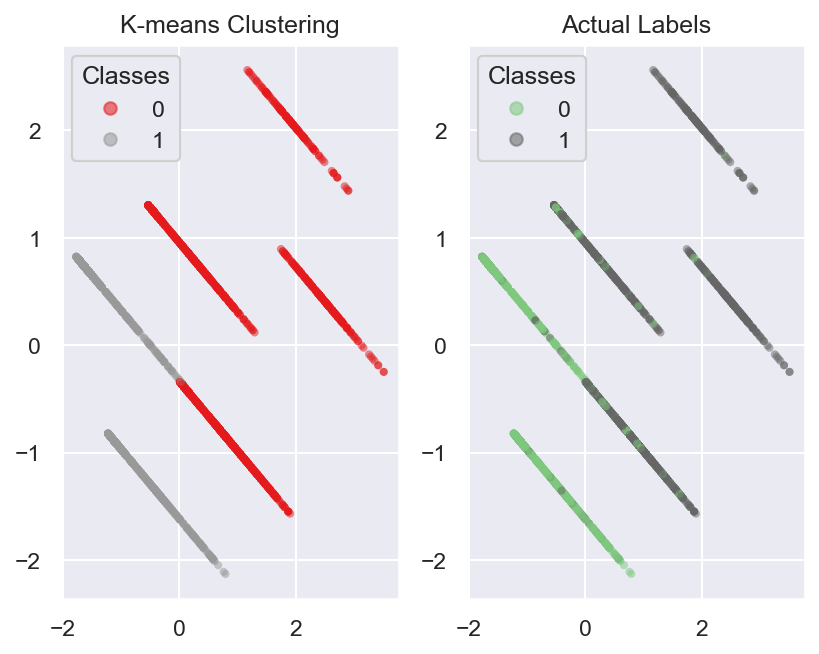

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
fig, (ax1, ax2) = plt.subplots(1, 2,dpi=150)

fig1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1],c=y_km, s=15, edgecolor='none', alpha=0.5,cmap=plt.cm.get_cmap('Set1', 3))
fig2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1],c=y[:2500], s=15, edgecolor='none', alpha=0.5,cmap=plt.cm.get_cmap('Accent', 3))
ax1.set_title('K-means Clustering')
legend1 = ax1.legend(*fig1.legend_elements(), loc="best", title="Classes")
ax1.add_artist(legend1)
ax2.set_title('Actual Labels')
legend2 = ax2.legend(*fig2.legend_elements(), loc="best", title="Classes")
ax2.add_artist(legend2)

And now an evaluation of accuracy using the adjusted rand index.

In [66]:
from sklearn import metrics
metrics.adjusted_rand_score(y_km, y[:2500])

0.6683341564190269

Let us try to change the number of clusters to see if we can adjust the score.

In [67]:
from sklearn.cluster import KMeans
kmeans1 = KMeans(n_clusters=3, random_state=0) # now we change to 3 clusters
y_km1 = kmeans1.fit_predict(X[:2500,:]) # sliced array

In [68]:
from sklearn.decomposition import PCA
pca1 = PCA(n_components=2)
X_pca1 = pca.fit_transform(X[:2500,:]) # sliced array

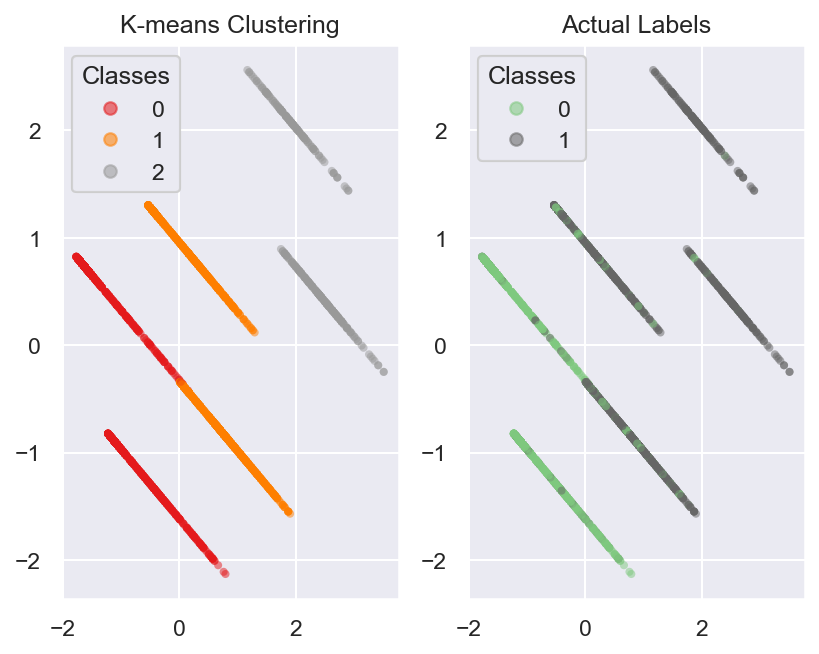

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
fig1, (ax11, ax12) = plt.subplots(1, 2,dpi=150)

fig11 = ax11.scatter(X_pca1[:, 0], X_pca1[:, 1],c=y_km1, s=15, edgecolor='none', alpha=0.5,cmap=plt.cm.get_cmap('Set1', 3))
fig12 = ax12.scatter(X_pca1[:, 0], X_pca1[:, 1],c=y[:2500], s=15, edgecolor='none', alpha=0.5,cmap=plt.cm.get_cmap('Accent', 3))
ax11.set_title('K-means Clustering')
legend11 = ax11.legend(*fig11.legend_elements(), loc="best", title="Classes")
ax11.add_artist(legend11)
ax12.set_title('Actual Labels')
legend12 = ax12.legend(*fig12.legend_elements(), loc="best", title="Classes")
ax12.add_artist(legend12)

In [70]:
from sklearn import metrics
metrics.adjusted_rand_score(y_km1, y[:2500])

0.5216612755978869

**Observations**:
\
The data visualization is quite strange looking. This is likely related to the feature selection we performed on the data set. Our score is not very exciting either. In order to improve this model, it would perhaps require a complete revamp of our classification problem that we identified at the beginning of this project, adjust how we did the feature selection, or examine the data again by performing more exploratory data analysis.
\
\
To comment on our two attempts at creating a model above, it seems the increasing the number of clusters resulted a significant loss in acccuracy.

### tSNE (t-distributed stochastic neighbor embedding)

Our K-means Clustering was quite unsuccessful and produced a very strange result, so we will try something that should (hopefully) give us something a bit cleaner. For our very last model, we will use tSNE which will reduce the dimension of our data. The idea with tSNE is, if we perform a random walk in the embedded low-dimensional space, it should be similar to the random walk on high-dimensional data. We will import TSNE from sklearn.manifold to allow us to create in instance of the model. Then we use matplotlib and seaborn to visualize the data. Additionally, we need to trim our data down a tiny bit, or else we tend to run into some issues with the visualization looking quite messy.

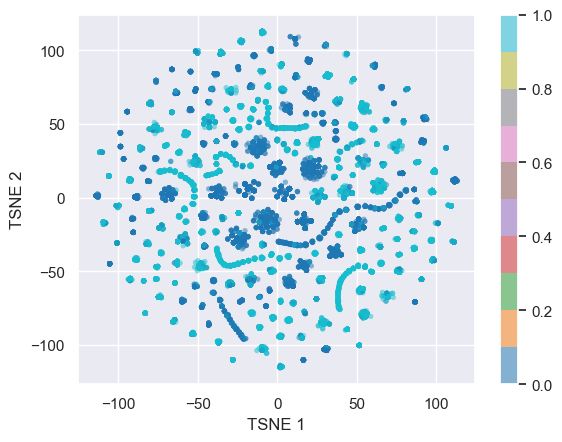

In [71]:
from sklearn.manifold import TSNE
tsne = TSNE(n_jobs = -1)
X_tsne = tsne.fit_transform(X[:15000,:]) #We have chosen to use 15,000 entries from the data set


import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
figure = plt.figure(dpi=100)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1],c=y[:15000], s=15, edgecolor='none', alpha=0.5,cmap=plt.cm.get_cmap('tab10', 10))
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.colorbar();

**Observations**:
\
This looks infinitely more interesting than the K-Means Clustering that we did earlier. The data forms quite a unique looking pattern here. Of course, since this is a binary classification problem we only have the color set to represent either a 1 or 0. For instance, observe the center of the graph, we seem to have a high concentration of one outcome.

## Conclusion

In summary, we seem to have experienced a decent amount of success with our supervised learning models. An accuracy rate of around 90% at predicting whether or not a person has had damage to their vehicle just based off of gender, age, insurance history, and expression of interest in insurance is fascinating. Our unsupervised learning models produced unexpected results. The K-Means Clustering was not as successful as one would hope, but the tSNE visualization is quite intruiging, as it contains such a strange looking pattern. 
\
\
There is defintely room for improvement in our unsupervised learning models. Perhaps there are alternative methods that would have given more insight, such as principal component analysis. As mentioned eariler, there may be issues with the feature selection that we performed as well. To conclude, it may be a good idea for users to further explore the identified classification problem by taking note of our successes and failures in this project and heavily adjust the bounds that we operated within. 

**Acknowledgements**:
\
Professor Peijie Zhou's lecture notes